In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from tools import compute_PCA, compute_TSNE, load_data

In [2]:
X, y, p = load_data([ps for ps in range(1, 16)], z_score_norm="participant_meanfree")
X = X.reshape(X.shape[0], X.shape[1] * X.shape[1])

load: ['P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15']
before: 0.010833320819703356 0.0138765904356241
after global: 3.3453047822980234e-16 1.0
before: 0.014157458413294332 0.019697427174936128
after global: 5.144634718234897e-16 0.9999999999999999
before: 0.009671310470783361 0.01382165546457677
after global: 5.894732537024589e-17 0.9999999999999996
before: 0.014321327169414132 0.02092426207628347
after global: -8.412627794765627e-17 0.9999999999999994
before: 0.008012871473850146 0.008465251726686069
after global: -2.9350674187145196e-16 0.9999999999999999
before: 0.015501076883670332 0.020161922062374903
after global: -2.3778118615833976e-16 0.9999999999999998
before: 0.005785778427333883 0.008299444524589267
after global: -9.745232778682356e-18 1.0
before: 0.01421073297731075 0.016707890764832815
after global: -1.4497636640483996e-16 0.9999999999999998
before: 0.0105969642036091 0.012696071282817526
after global: 2.4956514487

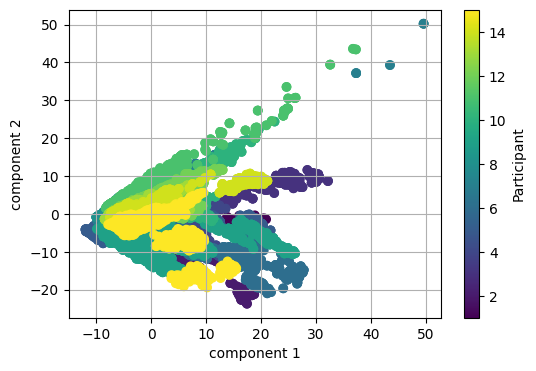

In [3]:
compute_PCA(
    X,
    feature=p,
    feature_label="Participant",
)

In [4]:
X.shape, y.shape

((67615, 256), (67615,))

**3 level classification***

- low torque
- medium torque 
- high torque

In [5]:
def classification(y, levels=3, prints: bool = True):
    if levels == 3:
        lower_bound = np.percentile(y, 33.3)
        upper_bound = np.percentile(y, 66.6)

        categories = list()
        labels = list()

        for value in y:
            if value <= lower_bound:
                categories.append(0)
                labels.append("low")
            elif value <= upper_bound:
                categories.append(1 / 2)
                labels.append("medium")
            else:
                categories.append(1)
                labels.append("high")

        categories = np.array(categories)
        labels = np.array(labels)
        if prints:
            print(
                "low:",
                len(np.where(labels == "low")[0]),
                "medium:",
                len(np.where(labels == "medium")[0]),
                "high:",
                len(np.where(labels == "high")[0]),
            )
    elif levels == 2:
        bound = np.percentile(y, 50.0)

        categories = list()
        labels = list()

        for value in y:
            if value <= bound:
                categories.append(0)
                labels.append("low")
            else:
                categories.append(1)
                labels.append("high")

        categories = np.array(categories)
        labels = np.array(labels)
        if prints:
            print(
                "low:",
                len(np.where(labels == "low")[0]),
                "high:",
                len(np.where(labels == "high")[0]),
            )
    return categories, labels

In [6]:
y_cat, y_lab = classification(y, 3)

low: 22516 medium: 22515 high: 22584


In [7]:
y_cat

array([0., 0., 0., ..., 0., 0., 0.])

In [8]:
y_lab

array(['low', 'low', 'low', ..., 'low', 'low', 'low'], dtype='<U6')

In [7]:
selcts = np.where(y_lab == "low")[0]
print("low range:\t", np.min(y[selcts]), np.max(y[selcts]))
selcts = np.where(y_lab == "medium")[0]
print("medium range:\t", np.min(y[selcts]), np.max(y[selcts]))
selcts = np.where(y_lab == "high")[0]
print("high range:\t", np.min(y[selcts]), np.max(y[selcts]))

low range:	 -4.572675665422792 28.74549343455326
medium range:	 28.745495904478243 49.542848801773815
high range:	 49.542973275363245 125.50900164458406


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_lab, test_size=0.2, random_state=42
)

**SVM Method**

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train SVM model
svm_model = SVC(kernel="rbf")
svm_model.fit(X_train, y_train)

SVC()

In [11]:
y_pred_svm = svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {accuracy_svm:.2f}")
cm_svm = confusion_matrix(y_test, y_pred_svm)

SVM Accuracy: 0.82


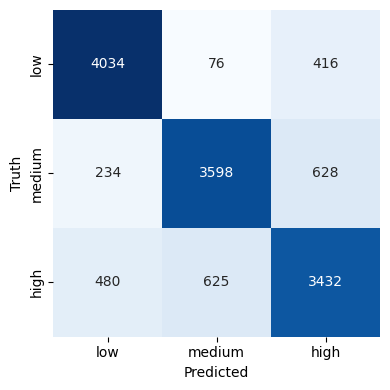

              precision    recall  f1-score   support

         low       0.85      0.89      0.87      4526
      medium       0.84      0.81      0.82      4460
        high       0.77      0.76      0.76      4537

    accuracy                           0.82     13523
   macro avg       0.82      0.82      0.82     13523
weighted avg       0.82      0.82      0.82     13523



In [26]:
plt.figure(figsize=(4, 4))
sns.heatmap(
    cm_svm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=["low", "medium", "high"],
    yticklabels=["low", "medium", "high"],
)
plt.xlabel("Predicted")
plt.ylabel("Truth")
# plt.title("SVM")
plt.tight_layout()
plt.savefig("imgs/CM_SVM_good.pdf")
plt.show()

print(classification_report(y_test, y_pred_svm, target_names=["low", "medium", "high"]))

**Random forest**

In [15]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")

Random Forest Accuracy: 0.98


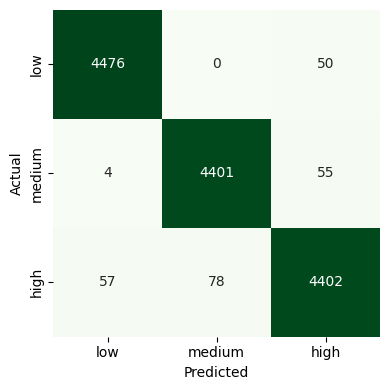

              precision    recall  f1-score   support

         low       0.99      0.99      0.99      4526
      medium       0.98      0.99      0.98      4460
        high       0.98      0.97      0.97      4537

    accuracy                           0.98     13523
   macro avg       0.98      0.98      0.98     13523
weighted avg       0.98      0.98      0.98     13523



In [25]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(4, 4))
sns.heatmap(
    cm_rf,
    annot=True,
    fmt="d",
    cbar=False,
    cmap="Greens",
    xticklabels=["low", "medium", "high"],
    yticklabels=["low", "medium", "high"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
# plt.title("Confusion Matrix - Random Forest")
plt.tight_layout()
plt.savefig("imgs/CM_RF_good.pdf")
plt.show()

print(classification_report(y_test, y_pred_rf, target_names=["low", "medium", "high"]))

### Test with unknown participant

In [12]:
X, y, p = load_data(
    [1, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13], z_score_norm="participant_meanfree"
)
X_train = X.reshape(X.shape[0], X.shape[1] * X.shape[1])
_, y_train = classification(y)

X_test, y_test, p_test = load_data([14], z_score_norm="participant_meanfree")
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[1])

# test data of participant
_, y_test = classification(y_test)

load: ['P01', 'P03', 'P04', 'P05', 'P06', 'P07', 'P09', 'P10', 'P11', 'P12', 'P13']
before: 0.010833320819703356 0.0138765904356241
after global: 3.3453047822980234e-16 1.0
before: 0.009671310470783361 0.01382165546457677
after global: 5.894732537024589e-17 0.9999999999999996
before: 0.014321327169414132 0.02092426207628347
after global: -8.412627794765627e-17 0.9999999999999994
before: 0.008012871473850146 0.008465251726686069
after global: -2.9350674187145196e-16 0.9999999999999999
before: 0.015501076883670332 0.020161922062374903
after global: -2.3778118615833976e-16 0.9999999999999998
before: 0.005785778427333883 0.008299444524589267
after global: -9.745232778682356e-18 1.0
before: 0.0105969642036091 0.012696071282817526
after global: 2.4956514487339933e-16 1.0
before: 0.01125014743993877 0.015176670562493291
after global: -2.5283174943567163e-16 0.9999999999999997
before: 0.010497400251044876 0.011441049062675797
after global: -9.633351723722724e-17 0.9999999999999997
before: 0.01

Random Forest Accuracy: 0.28


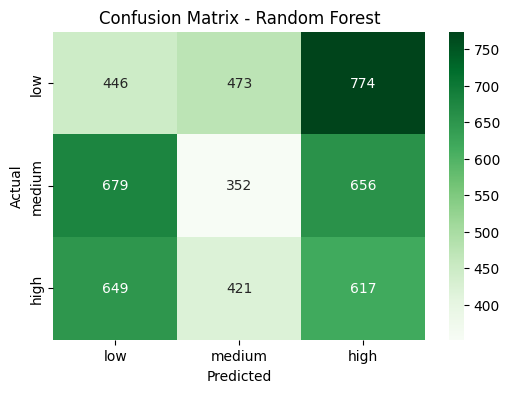

              precision    recall  f1-score   support

         low       0.25      0.26      0.26      1693
      medium       0.28      0.21      0.24      1687
        high       0.30      0.37      0.33      1687

    accuracy                           0.28      5067
   macro avg       0.28      0.28      0.28      5067
weighted avg       0.28      0.28      0.28      5067



In [13]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm_rf,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["low", "medium", "high"],
    yticklabels=["low", "medium", "high"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

print(classification_report(y_test, y_pred_rf, target_names=["low", "medium", "high"]))

### Test with unknown participant - crossvadidation

Train participant: [ 2  3  4  5  6  7  9 10 11 12 13 14]
Test participant: 1
low: 19463 medium: 19463 high: 19522
low: 707 medium: 707 high: 710
SVM Accuracy: 0.35


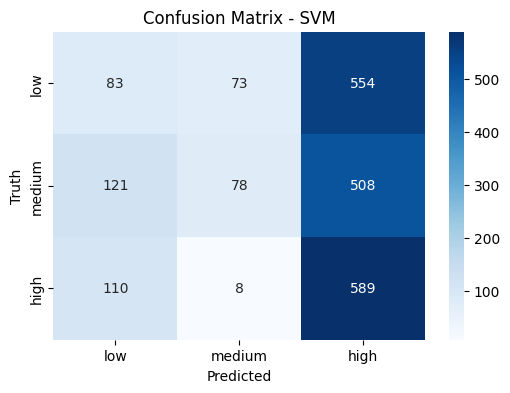

              precision    recall  f1-score   support

         low       0.26      0.12      0.16       710
      medium       0.49      0.11      0.18       707
        high       0.36      0.83      0.50       707

    accuracy                           0.35      2124
   macro avg       0.37      0.35      0.28      2124
weighted avg       0.37      0.35      0.28      2124

Train participant: [ 1  3  4  5  6  7  9 10 11 12 13 14]
Test participant: 2
low: 18839 medium: 18838 high: 18895
low: 1332 medium: 1332 high: 1336
SVM Accuracy: 0.41


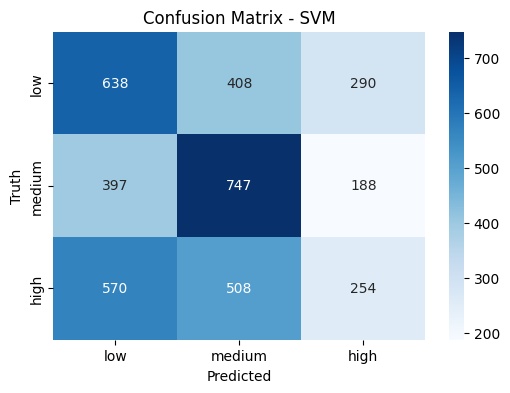

              precision    recall  f1-score   support

         low       0.40      0.48      0.43      1336
      medium       0.45      0.56      0.50      1332
        high       0.35      0.19      0.25      1332

    accuracy                           0.41      4000
   macro avg       0.40      0.41      0.39      4000
weighted avg       0.40      0.41      0.39      4000

Train participant: [ 1  2  4  5  6  7  9 10 11 12 13 14]
Test participant: 3
low: 18643 medium: 18642 high: 18699
low: 1528 medium: 1527 high: 1533
SVM Accuracy: 0.25


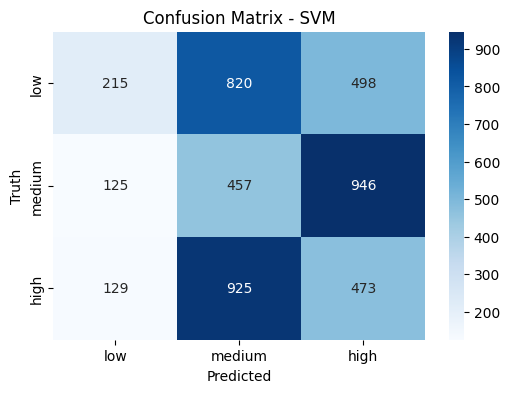

              precision    recall  f1-score   support

         low       0.46      0.14      0.21      1533
      medium       0.21      0.30      0.25      1528
        high       0.25      0.31      0.27      1527

    accuracy                           0.25      4588
   macro avg       0.30      0.25      0.24      4588
weighted avg       0.30      0.25      0.24      4588

Train participant: [ 1  2  3  5  6  7  9 10 11 12 13 14]
Test participant: 4
low: 18654 medium: 18654 high: 18711
low: 1516 medium: 1516 high: 1521
SVM Accuracy: 0.24


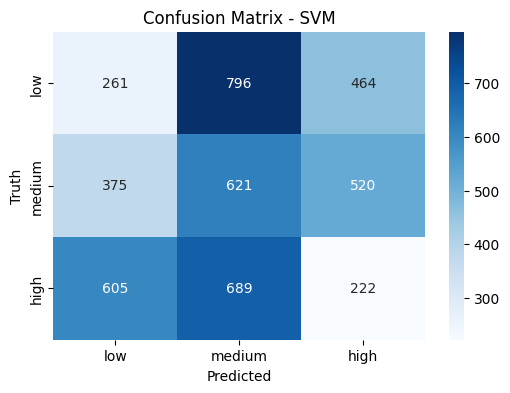

              precision    recall  f1-score   support

         low       0.21      0.17      0.19      1521
      medium       0.29      0.41      0.34      1516
        high       0.18      0.15      0.16      1516

    accuracy                           0.24      4553
   macro avg       0.23      0.24      0.23      4553
weighted avg       0.23      0.24      0.23      4553

Train participant: [ 1  2  3  4  6  7  9 10 11 12 13 14]
Test participant: 5
low: 18452 medium: 18452 high: 18507
low: 1719 medium: 1718 high: 1724
SVM Accuracy: 0.33


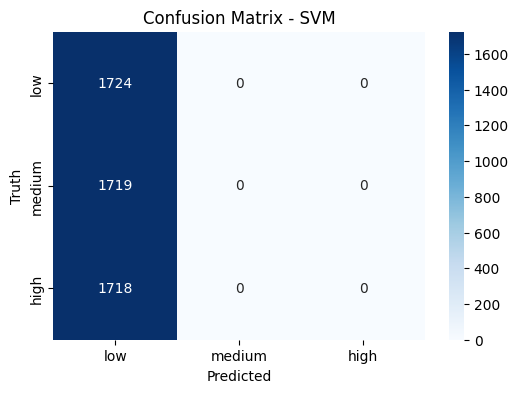

              precision    recall  f1-score   support

         low       0.33      1.00      0.50      1724
      medium       0.00      0.00      0.00      1719
        high       0.00      0.00      0.00      1718

    accuracy                           0.33      5161
   macro avg       0.11      0.33      0.17      5161
weighted avg       0.11      0.33      0.17      5161

Train participant: [ 1  2  3  4  5  7  9 10 11 12 13 14]
Test participant: 6


/home/jt292/miniconda3/envs/TF/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jt292/miniconda3/envs/TF/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jt292/miniconda3/envs/TF/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


low: 18378 medium: 18378 high: 18433
low: 1793 medium: 1792 high: 1798
SVM Accuracy: 0.25


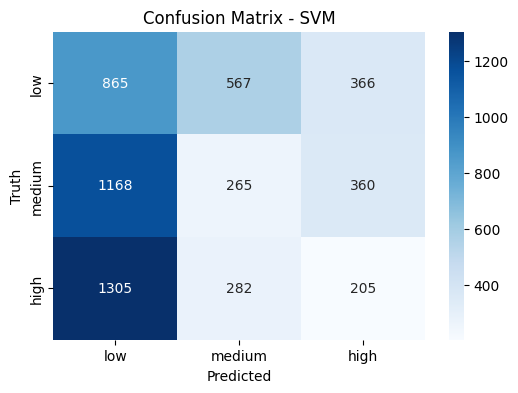

              precision    recall  f1-score   support

         low       0.26      0.48      0.34      1798
      medium       0.24      0.15      0.18      1793
        high       0.22      0.11      0.15      1792

    accuracy                           0.25      5383
   macro avg       0.24      0.25      0.22      5383
weighted avg       0.24      0.25      0.22      5383

Train participant: [ 1  2  3  4  5  6  9 10 11 12 13 14]
Test participant: 7
low: 18759 medium: 18759 high: 18816
low: 1411 medium: 1411 high: 1416
SVM Accuracy: 0.41


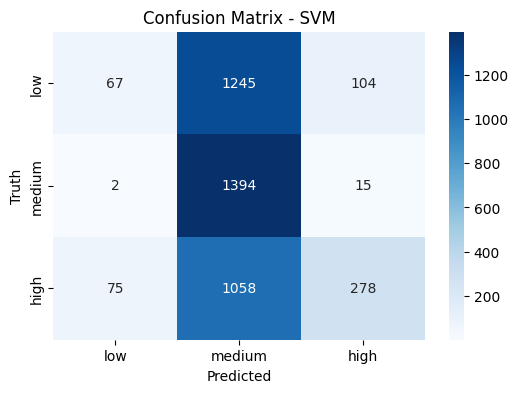

              precision    recall  f1-score   support

         low       0.47      0.05      0.09      1416
      medium       0.38      0.99      0.55      1411
        high       0.70      0.20      0.31      1411

    accuracy                           0.41      4238
   macro avg       0.51      0.41      0.31      4238
weighted avg       0.51      0.41      0.31      4238

Train participant: [ 1  2  3  4  5  6  7 10 11 12 13 14]
Test participant: 8
low: 18440 medium: 18440 high: 18496


/home/jt292/miniconda3/envs/TF/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jt292/miniconda3/envs/TF/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


IndexError: tuple index out of range

In [25]:
load_part_list = np.array([1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14])
for ps in range(1, len(load_part_list) + 1):
    new_arr = np.delete(load_part_list, ps - 1)
    print("Train participant:", new_arr)
    print("Test participant:", ps)

    X, y, p = load_data(new_arr, z_score_norm="participant_meanfree", print_info=False)
    X_train = X.reshape(X.shape[0], X.shape[1] * X.shape[1])
    _, y_train = classification(y)

    X_test, y_test, p_test = load_data(
        [ps], z_score_norm="participant_meanfree", print_info=False
    )
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[1])

    # test data of participant
    _, y_test = classification(y_test)

    # model
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Initialize and train SVM model
    svm_model = SVC(kernel="rbf")
    svm_model.fit(X_train, y_train)

    y_pred_svm = svm_model.predict(X_test)
    accuracy_svm = accuracy_score(y_test, y_pred_svm)
    print(f"SVM Accuracy: {accuracy_svm:.2f}")
    cm_svm = confusion_matrix(y_test, y_pred_svm)

    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm_svm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["low", "medium", "high"],
        yticklabels=["low", "medium", "high"],
    )
    plt.xlabel("Predicted")
    plt.ylabel("Truth")
    plt.title("Confusion Matrix - SVM")
    plt.show()

    print(
        classification_report(
            y_test, y_pred_svm, target_names=["low", "medium", "high"]
        )
    )

Train participant: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Test participant: 1
low: 21809 medium: 21808 high: 21874
low: 707 medium: 707 high: 710
Random Forest Accuracy: 0.36


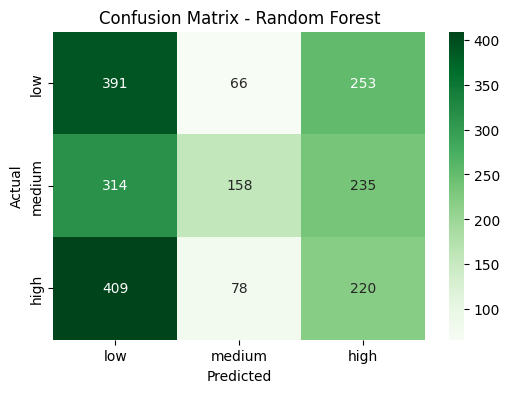

              precision    recall  f1-score   support

         low       0.35      0.55      0.43       710
      medium       0.52      0.22      0.31       707
        high       0.31      0.31      0.31       707

    accuracy                           0.36      2124
   macro avg       0.39      0.36      0.35      2124
weighted avg       0.39      0.36      0.35      2124

Train participant: [ 1  3  4  5  6  7  8  9 10 11 12 13 14 15]
Test participant: 2
low: 21184 medium: 21183 high: 21248
low: 1332 medium: 1332 high: 1336
Random Forest Accuracy: 0.35


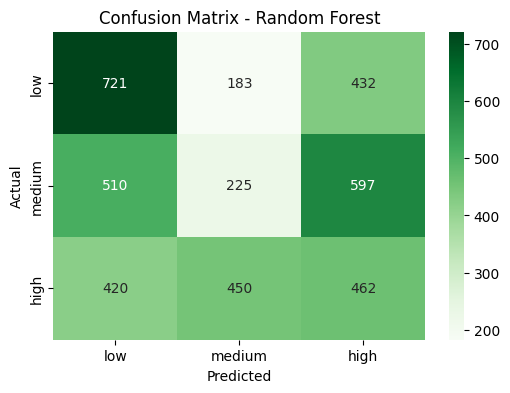

              precision    recall  f1-score   support

         low       0.44      0.54      0.48      1336
      medium       0.26      0.17      0.21      1332
        high       0.31      0.35      0.33      1332

    accuracy                           0.35      4000
   macro avg       0.34      0.35      0.34      4000
weighted avg       0.34      0.35      0.34      4000

Train participant: [ 1  2  4  5  6  7  8  9 10 11 12 13 14 15]
Test participant: 3
low: 20988 medium: 20988 high: 21051
low: 1528 medium: 1527 high: 1533
Random Forest Accuracy: 0.23


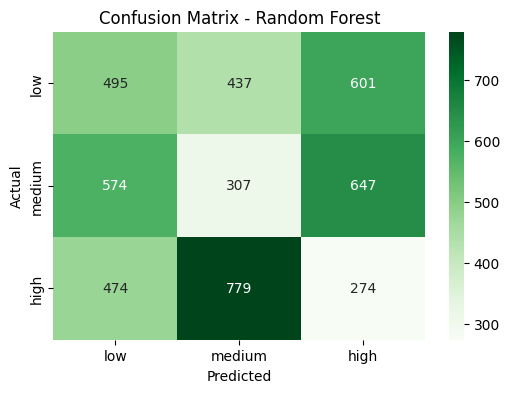

              precision    recall  f1-score   support

         low       0.32      0.32      0.32      1533
      medium       0.20      0.20      0.20      1528
        high       0.18      0.18      0.18      1527

    accuracy                           0.23      4588
   macro avg       0.23      0.23      0.23      4588
weighted avg       0.23      0.23      0.23      4588

Train participant: [ 1  2  3  5  6  7  8  9 10 11 12 13 14 15]
Test participant: 4
low: 21000 medium: 20999 high: 21063
low: 1516 medium: 1516 high: 1521
Random Forest Accuracy: 0.36


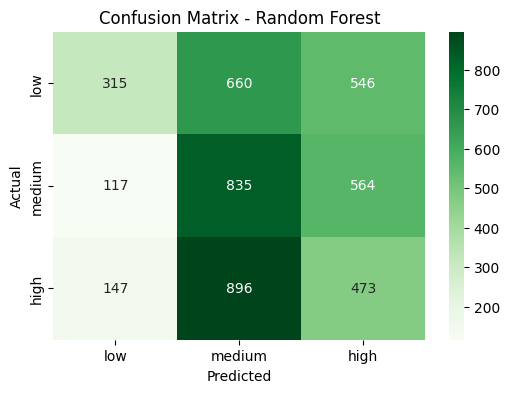

              precision    recall  f1-score   support

         low       0.54      0.21      0.30      1521
      medium       0.35      0.55      0.43      1516
        high       0.30      0.31      0.31      1516

    accuracy                           0.36      4553
   macro avg       0.40      0.36      0.34      4553
weighted avg       0.40      0.36      0.34      4553

Train participant: [ 1  2  3  4  6  7  8  9 10 11 12 13 14 15]
Test participant: 5
low: 20797 medium: 20797 high: 20860
low: 1719 medium: 1718 high: 1724
Random Forest Accuracy: 0.29


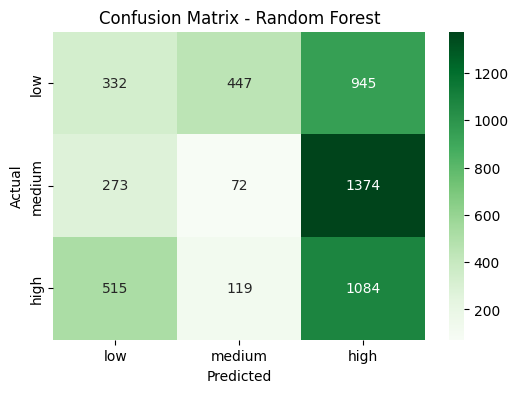

              precision    recall  f1-score   support

         low       0.30      0.19      0.23      1724
      medium       0.11      0.04      0.06      1719
        high       0.32      0.63      0.42      1718

    accuracy                           0.29      5161
   macro avg       0.24      0.29      0.24      5161
weighted avg       0.24      0.29      0.24      5161

Train participant: [ 1  2  3  4  5  7  8  9 10 11 12 13 14 15]
Test participant: 6
low: 20723 medium: 20723 high: 20786
low: 1793 medium: 1792 high: 1798
Random Forest Accuracy: 0.25


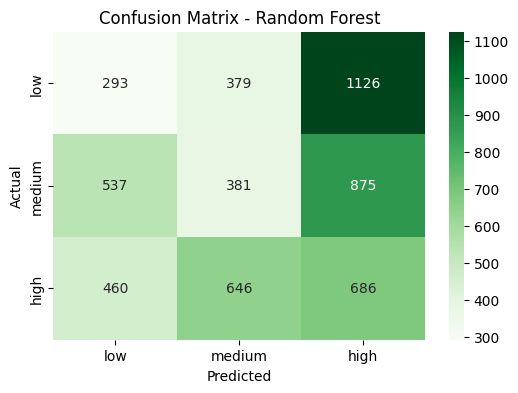

              precision    recall  f1-score   support

         low       0.23      0.16      0.19      1798
      medium       0.27      0.21      0.24      1793
        high       0.26      0.38      0.31      1792

    accuracy                           0.25      5383
   macro avg       0.25      0.25      0.24      5383
weighted avg       0.25      0.25      0.24      5383

Train participant: [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15]
Test participant: 7
low: 21105 medium: 21104 high: 21168
low: 1411 medium: 1411 high: 1416
Random Forest Accuracy: 0.38


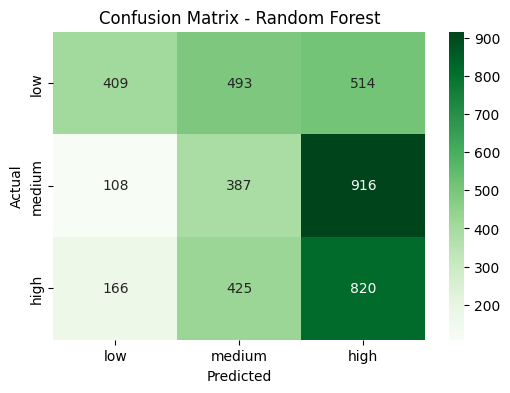

              precision    recall  f1-score   support

         low       0.60      0.29      0.39      1416
      medium       0.30      0.27      0.28      1411
        high       0.36      0.58      0.45      1411

    accuracy                           0.38      4238
   macro avg       0.42      0.38      0.37      4238
weighted avg       0.42      0.38      0.37      4238

Train participant: [ 1  2  3  4  5  6  7  9 10 11 12 13 14 15]
Test participant: 8
low: 20837 medium: 20836 high: 20900
low: 1679 medium: 1679 high: 1684
Random Forest Accuracy: 0.29


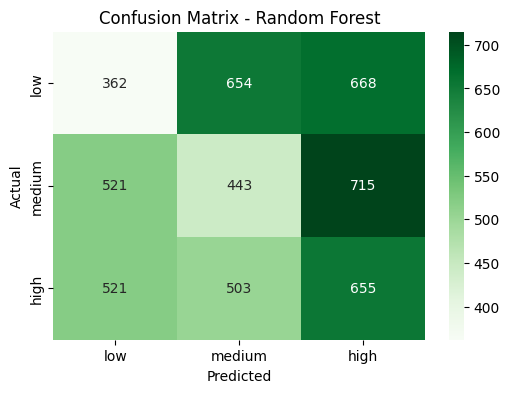

              precision    recall  f1-score   support

         low       0.26      0.21      0.23      1684
      medium       0.28      0.26      0.27      1679
        high       0.32      0.39      0.35      1679

    accuracy                           0.29      5042
   macro avg       0.29      0.29      0.29      5042
weighted avg       0.29      0.29      0.29      5042

Train participant: [ 1  2  3  4  5  6  7  8 10 11 12 13 14 15]
Test participant: 9
low: 20786 medium: 20785 high: 20848
low: 1730 medium: 1730 high: 1736
Random Forest Accuracy: 0.27


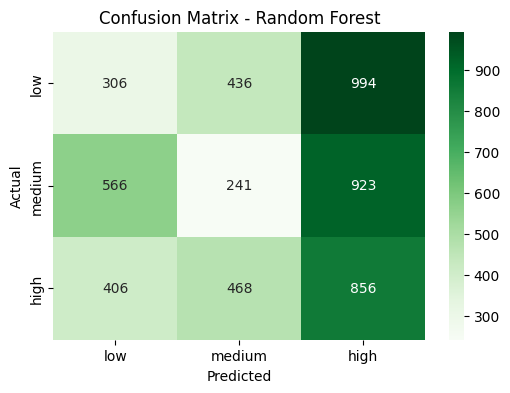

              precision    recall  f1-score   support

         low       0.24      0.18      0.20      1736
      medium       0.21      0.14      0.17      1730
        high       0.31      0.49      0.38      1730

    accuracy                           0.27      5196
   macro avg       0.25      0.27      0.25      5196
weighted avg       0.25      0.27      0.25      5196

Train participant: [ 1  2  3  4  5  6  7  8  9 11 12 13 14 15]
Test participant: 10
low: 20830 medium: 20829 high: 20893
low: 1686 medium: 1686 high: 1691
Random Forest Accuracy: 0.32


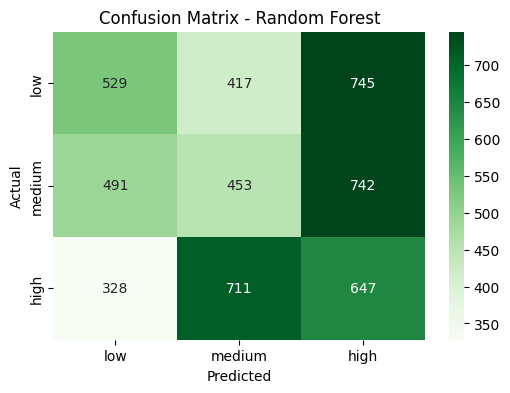

              precision    recall  f1-score   support

         low       0.39      0.31      0.35      1691
      medium       0.29      0.27      0.28      1686
        high       0.30      0.38      0.34      1686

    accuracy                           0.32      5063
   macro avg       0.33      0.32      0.32      5063
weighted avg       0.33      0.32      0.32      5063

Train participant: [ 1  2  3  4  5  6  7  8  9 10 12 13 14 15]
Test participant: 11
low: 21091 medium: 21091 high: 21155
low: 1425 medium: 1424 high: 1429
Random Forest Accuracy: 0.29


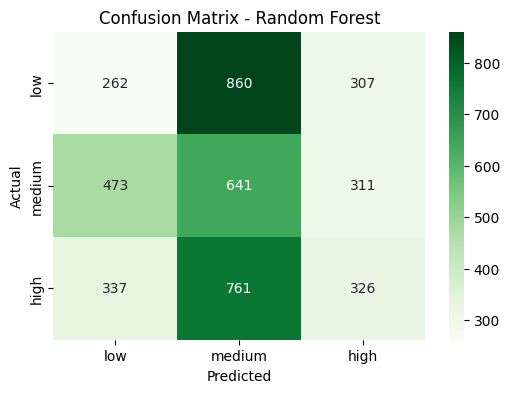

              precision    recall  f1-score   support

         low       0.24      0.18      0.21      1429
      medium       0.28      0.45      0.35      1425
        high       0.35      0.23      0.28      1424

    accuracy                           0.29      4278
   macro avg       0.29      0.29      0.28      4278
weighted avg       0.29      0.29      0.28      4278

Train participant: [ 1  2  3  4  5  6  7  8  9 10 11 13 14 15]
Test participant: 12
low: 20736 medium: 20736 high: 20799
low: 1780 medium: 1779 high: 1785
Random Forest Accuracy: 0.34


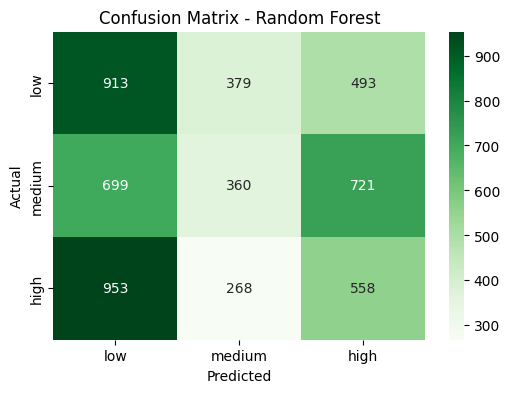

              precision    recall  f1-score   support

         low       0.36      0.51      0.42      1785
      medium       0.36      0.20      0.26      1780
        high       0.31      0.31      0.31      1779

    accuracy                           0.34      5344
   macro avg       0.34      0.34      0.33      5344
weighted avg       0.34      0.34      0.33      5344

Train participant: [ 1  2  3  4  5  6  7  8  9 10 11 12 14 15]
Test participant: 13
low: 20659 medium: 20658 high: 20721
low: 1857 medium: 1857 high: 1863
Random Forest Accuracy: 0.31


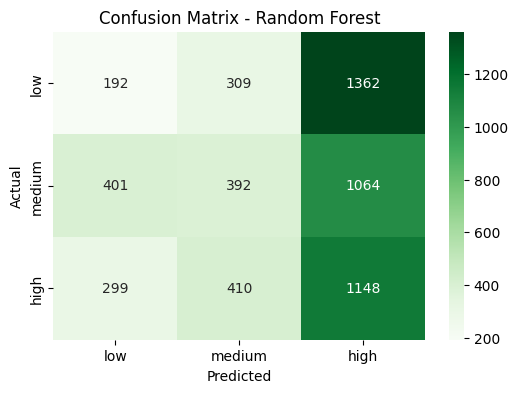

              precision    recall  f1-score   support

         low       0.22      0.10      0.14      1863
      medium       0.35      0.21      0.26      1857
        high       0.32      0.62      0.42      1857

    accuracy                           0.31      5577
   macro avg       0.30      0.31      0.28      5577
weighted avg       0.30      0.31      0.28      5577

Train participant: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 15]
Test participant: 14
low: 20829 medium: 20828 high: 20891
low: 1687 medium: 1687 high: 1693
Random Forest Accuracy: 0.29


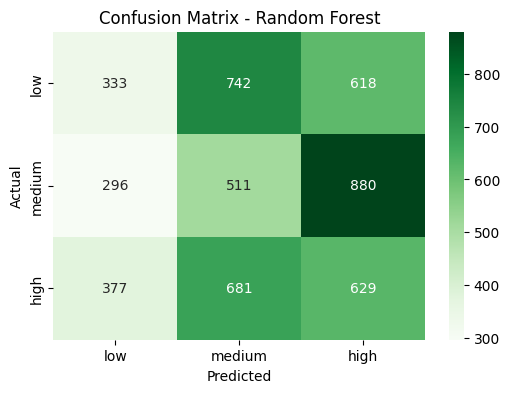

              precision    recall  f1-score   support

         low       0.33      0.20      0.25      1693
      medium       0.26      0.30      0.28      1687
        high       0.30      0.37      0.33      1687

    accuracy                           0.29      5067
   macro avg       0.30      0.29      0.29      5067
weighted avg       0.30      0.29      0.29      5067

Train participant: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Test participant: 15
low: 21850 medium: 21849 high: 21915
low: 666 medium: 667 high: 668
Random Forest Accuracy: 0.40


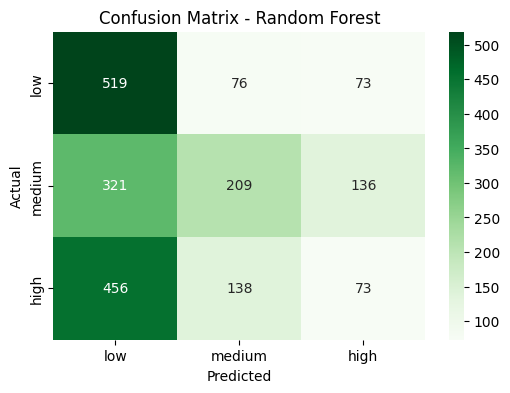

              precision    recall  f1-score   support

         low       0.40      0.78      0.53       668
      medium       0.49      0.31      0.38       666
        high       0.26      0.11      0.15       667

    accuracy                           0.40      2001
   macro avg       0.38      0.40      0.36      2001
weighted avg       0.38      0.40      0.36      2001



In [14]:
load_part_list = np.array([ps for ps in range(1, 16)])
for ps in range(1, len(load_part_list) + 1):
    new_arr = np.delete(load_part_list, ps - 1)
    print("Train participant:", new_arr)
    print("Test participant:", ps)

    X, y, p = load_data(new_arr, z_score_norm="participant_meanfree", print_info=False)
    X_train = X.reshape(X.shape[0], X.shape[1] * X.shape[1])
    _, y_train = classification(y)

    X_test, y_test, p_test = load_data(
        [ps], z_score_norm="participant_meanfree", print_info=False
    )
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[1])

    # test data of participant
    _, y_test = classification(y_test)

    # model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    y_pred_rf = rf_model.predict(X_test)

    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    print(f"Random Forest Accuracy: {accuracy_rf:.2f}")

    cm_rf = confusion_matrix(y_test, y_pred_rf)
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm_rf,
        annot=True,
        fmt="d",
        cmap="Greens",
        xticklabels=["low", "medium", "high"],
        yticklabels=["low", "medium", "high"],
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix - Random Forest")
    plt.show()

    print(
        classification_report(y_test, y_pred_rf, target_names=["low", "medium", "high"])
    )

**Multiclass classification**

In [32]:
X, y, p = load_data([ps for ps in range(1, 16)], z_score_norm="participant_meanfree")
X = X.reshape(X.shape[0], X.shape[1] * X.shape[1])

load: ['P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15']
before: 0.010833320819703356 0.0138765904356241
after global: 3.3453047822980234e-16 1.0
before: 0.014157458413294332 0.019697427174936128
after global: 5.144634718234897e-16 0.9999999999999999
before: 0.009671310470783361 0.01382165546457677
after global: 5.894732537024589e-17 0.9999999999999996
before: 0.014321327169414132 0.02092426207628347
after global: -8.412627794765627e-17 0.9999999999999994
before: 0.008012871473850146 0.008465251726686069
after global: -2.9350674187145196e-16 0.9999999999999999
before: 0.015501076883670332 0.020161922062374903
after global: -2.3778118615833976e-16 0.9999999999999998
before: 0.005785778427333883 0.008299444524589267
after global: -9.745232778682356e-18 1.0
before: 0.01421073297731075 0.016707890764832815
after global: -1.4497636640483996e-16 0.9999999999999998
before: 0.0105969642036091 0.012696071282817526
after global: 2.4956514487

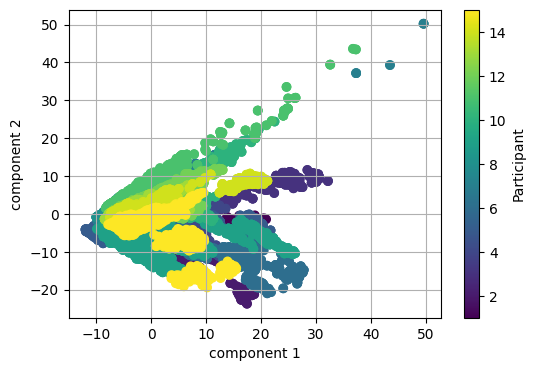

In [33]:
compute_PCA(
    X,
    feature=p,
    feature_label="Participant",
)

In [52]:
X_mc = list()
Y_mc = list()
for xs, ys in zip(X, y):
    yr = np.round(ys, -1)
    if yr >= 10 and yr <= 80:
        X_mc.append(xs)
        Y_mc.append(yr)
X_mc = np.array(X_mc)
Y_mc = np.array(Y_mc)

In [53]:
X_mc.shape, Y_mc.shape

((64642, 256), (64642,))

In [54]:
np.unique(Y_mc)

array([10., 20., 30., 40., 50., 60., 70., 80.])